## Tutorial 1: Optical Satellite Imagery Introduction
---

*Authors: [Joe Fennell](https://github.com/joe-fennell/), [Therese Cantwell](https://github.com/TMCantwell/), [Andrés Aguilar Ariza](https://github.com/anaguilarar/) & [Anna Scaife](https://github.com/as595/).*

---

<div class="alert alert-block alert-info">
<b>Objective:</b> You will use data from the Sentinel-2 satellite to estimate the percentage of 'green space' in a region of central London.
</div>

Artificial satellites have many functions in communications, telemetry (e.g. GPS), scientific research (e.g. astronomy) and earth observation. In this tutorial we're going to look at data from the European Space Agency [Sentinel-2 satellite](http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2).

---

### Introduction to images

So first of all, what is an image? There's nothing special about an image array: when we have at least 2 spatial dimensions to work with (i.e. $x$ and $y$), we call these datasets 'images'. An image may be *monochrome* (i.e. with information gathered at a single frequency) or *colour* (i.e. with data at multiple frequencies).

Images are made up of pixels. In a monochrome image, every pixel is represented by a single value: the brightness. If we are looking at an image of a real object, the pixel value is proportional to the amount of light reflected by the object and absorbed by the camera sensor.

Computers represent colours in terms of their red, green and blue brightnesses. The [different mixtures or ratios of these three brightnesses give different colours](https://en.wikipedia.org/wiki/RGB_color_model). We sometimes refer to this kind of colour image as an *RGB image*. Every pixel in an RGB colour image has 3 values: one for each of the red, green and blue channels.

The Sentinel-2 satellite gathers *multi-spectral image data*. In addition to red, green and blue, it also captures a band in the *infrared*.


---

### Loading the data:

Let's start by loading an image from the Sentinel-2 satellite. The format of this image is a [numpy array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) and we'll display it using the [matplotlib library](https://matplotlib.org), so the first thing we need to do is to load those libraries:

In [21]:
import matplotlib.pyplot as plt
import numpy as np

Then we can read in the dataset. The input file is called <code>S2_London.npy</code> and it's stored in the <code>data</code> directory. 

We will use the [numpy library](https://www.numpy.org) to load this file and read the data from it into a [numpy array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) called **im1**:

In [22]:
# read in the dataset
im1 = np.load('data/S2_London.npy')

---

### Exploring the data:

Because **im1** is a [numpy array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) we can use the [numpy *shape* property](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html) to find out the dimensions of the data array:

In [23]:
print('Array dimensions: ',im1.shape)

Array dimensions:  (1000, 1000, 4)


We can see that the **im1** dataset is a 3-dimensional array with size 1000 x 1000 x 4. The first two values are telling us the size of the image in spatial dimensions, i.e. the image has 1000 x 1000 pixels. 

The third value is telling us how many channels each pixel has - in this case the Sentinel-2 data provides us with *four* brightness values: *blue*, *green*, *red* and *infrared*. 

---

### Plotting the data:

The brightness values in the Sentinel 2 data are surface level reflectance values and the data we're using here have been corrected for the effect of the atmosphere. These data are expressed as values in range 0-10000 (actually, sometimes these values can be larger than 10000, but we will ignore that for now) where 10000 represents a 100% reflectance. 

Each pixel in our dataset has four brightness values. These values represent how high the reflectance was in each of the four colour bands. Note that for these Sentinel-2 data the order of the bands is: (blue, green, red, infrared). For example, Band 1 ([index:0 for Python arrays](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.indexing.html)) is the blue band. A high value in the blue band means that the surface reflected lots of blue light back to the sensor onboard the satellite. Conversely, if we had a low value, we would know that the surface would be less reflective in the blue.
 
We can use the [matplotlib library](https://matplotlib.org) to display the **im1** data. The matplotlib [imshow](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function can interpret RGB data directly, but the brightness values need to be normalised, either from [0,1] if the data values are [floating point numbers](https://en.wikipedia.org/wiki/Floating-point_arithmetic#Floating-point_numbers) or from [0,255]  if the data values are [integers](https://en.wikipedia.org/wiki/Integer). 

Let's quickly check what kind of data values we have in the **im1** data array using the [numpy *dtype* property](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html):

In [24]:
print("Data type: ",im1.dtype)

Data type:  float64


We can see that our data values are floating point numbers, so we need to normalise them to lie between [0,1], and we also only want to select the first three channels corresponding to RGB (i.e. ignore the infrared channel):

#### A note about generating nice looking RGB images

Sentinel 2 data are surface level reflectance values. These are integer values in range 0-10000 (actually, sometimes these values can be larger than 10000, but we will ignore that for now) where 10,000 represents 100% reflectance.

So it might make sense to divide all values by 10,000 to put them in the range 0-1 and make them interpretable by matplotlib as RGB coordinates



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


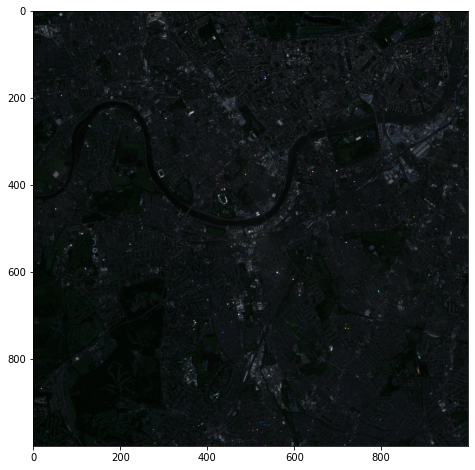

In [25]:
plt.figure(figsize=(8,8))
plt.imshow(im1[:,:,:3]/10000)
plt.show()

There are two things to notice here:

* Firstly, this is not a great image. We can't really see anything.
* Secondly, a warning has appeared when we ran the matplotlib functions.

Let's start with the second of these issues: the warning is telling us that the data have been *clipped* to lie within the acceptable range [0,1]. This means that there were either some data values that had a value higher than one *or* less than zero in the normalised input data.

We can check that by using the numpy library <code>max</code> and <code>min</code> functions:

In [26]:
print("Maximum data value: ",np.max(im1[:,:,:3]/10000))
print("Minimum data value: ",np.min(im1[:,:,:3]/10000))

Maximum data value:  2.1204
Minimum data value:  0.0003


It looks like the problem is the *maximum* value. There are obviously some misbehaving pixels and we'll come back to this later. 

First let's normalised the colour channels so that the image resembles more what we would actually see. This will make it easier to interpret. We're going to use a method called [histogram equalisation](https://en.wikipedia.org/wiki/Histogram_equalization) and to implement this method we're going to define a function of our own:

In [27]:
def image_histogram_equalization(image):
    
    """ 
    Function to perform image histogram equalisation.
    
    Method from: 
    http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html
    """
    
    # get histogram of data values using the numpy histogram function:
    image_histogram, bins = np.histogram(image.flatten(), 256, density=True)
    
    # use this to make a cumulative distribution function:
    cdf = image_histogram.cumsum() 
    
    # normalise the CDF:
    cdf = (255-1) * cdf / cdf[-1]

    # use linear interpolation of the CDF to find new pixel values:
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
    if len(image.shape) == 3:
        return image_equalized.reshape(image.shape).astype('uint8')[:,:,::-1]
    else:
        return image_equalized.reshape(image.shape).astype('uint8')
    

Now let's run this function on our **im1** data array. We will call the output **im1_equalized**. 

Note that we're *only passing the RGB channels to the <code>image_histogram_equalization</code> function*:

In [28]:
im1_equalized = image_histogram_equalization(im1[:,:,:3])

Now let's use matplotlib to display the result:

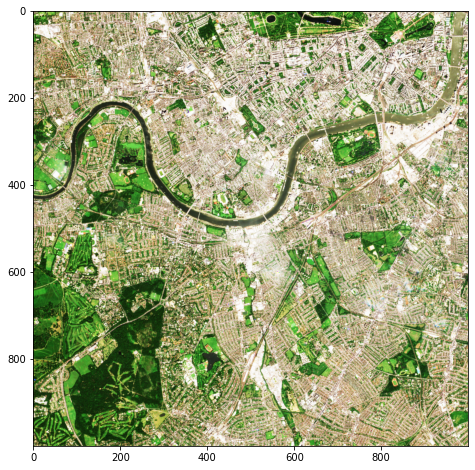

In [29]:
plt.figure(figsize=(8,8))
plt.imshow(im1_equalized)
plt.show()

That's looking better!

If we want, we can also display the individual colour channels. Remember that the data vlues are just telling us how bright each pixel is in a particular frequency band, so the individual channel data will appear as *monochrome*.

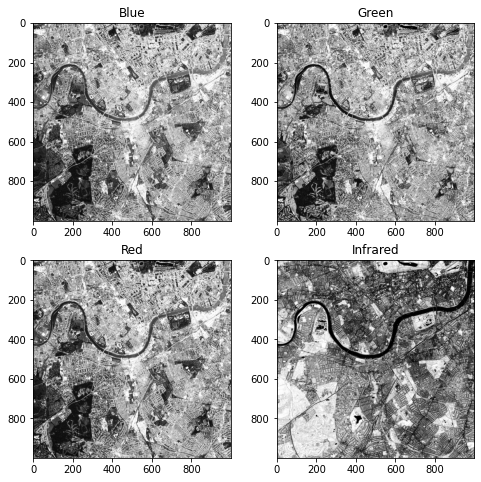

In [30]:
f = plt.figure(figsize=(8,8))

f.add_subplot(221)
plt.imshow(image_histogram_equalization(im1[:,:,0]),'binary_r')
plt.title('Blue')

f.add_subplot(222)
plt.imshow(image_histogram_equalization(im1[:,:,1]),'binary_r')
plt.title('Green')

f.add_subplot(223)
plt.imshow(image_histogram_equalization(im1[:,:,2]),'binary_r')
plt.title('Red')

f.add_subplot(224)
plt.imshow(image_histogram_equalization(im1[:,:,3]),'binary_r')
plt.title('Infrared')
plt.show()

---

### Using the data:

Usually, we aren't interested in the absolute brightness of each channel and so we prefer to use the ratios of brightness between channels.

For example, we can calculate a reflectance (R) ratio called the [Normalised Differential Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index):

$$
R_{\rm NDVI}=\frac{(R_{\rm IR}-R_{\rm red})}{(R_{\rm IR}+R_{\rm red})}.
$$

This ignores the overall brightness and just indicates the relative difference in reflectance between 2 wavebands, infrared and red.

To calculate the NDVI for this image, let's define a function to calculate it:

In [31]:
def calculate_NDVI(image):
    
    """ 
    This function calculates the Normalised Differential Vegetation Index 
    for the 4-band data provided in this exercise. 
    """
    
    # Extract the red channel from the Sentinel-2 data:
    red = image[:,:,2]
    
    # Extract the infrared channel from the Sentinel-2 data:
    ir = image[:,:,3]
    
    return (ir-red)/(ir+red)

Let's run this function on our **im1** data. We will call the output **im1_ndvi**:

In [32]:
# calculate NDVI
im1_ndvi = calculate_NDVI(im1)

Now let's use matplotlib to display the result:

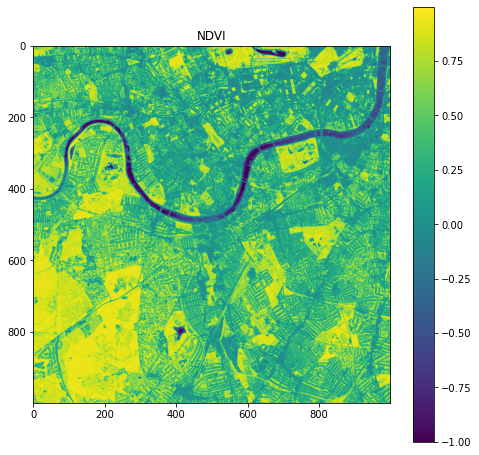

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(im1_ndvi,'viridis')
plt.title('NDVI')
plt.colorbar()
plt.show()

---

* **Question:** Why is the water so easy to identify using NDVI? Here is a [clue](https://en.wikipedia.org/wiki/Water#Color_and_appearance).
* **Question:** Does vegetation have high or low values of NDVI? Here is a [clue](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index).

---

We can filter the data so that we're only left with pixels which satisfy certain conditions. Let's set some thresholds: 

* Water: $-0.25$
* Vegetation: $0.50$

In [34]:
water_threshold = -0.25
vegetation_threshold = 0.50

We can then make a *mask* for our image that indicates where the water or vegetation is. The mask will have a value of <code>True</code> or <code>False</code> for each pixel in the image.

In [35]:
# keep all values bigger than the vegetation_threshold
mask = im1_ndvi > vegetation_threshold

and we can use that mask to calculate what area in the image is covered by vegetation. We do this by summing all the pixels in the mask that are <code>True</code> and multiplying them by the area of a pixel (for Sentinel-2 this is 10 x 10 metres, so an area of 100 square-metres per pixel).

In [36]:
# calculate the area above threshold in square-metres:
area = mask.sum()*100

# convert to square-kilometres:
area/= 1e6 

print("Area covered by vegetation: ",area," sq-km")

Area covered by vegetation:  41.2522  sq-km


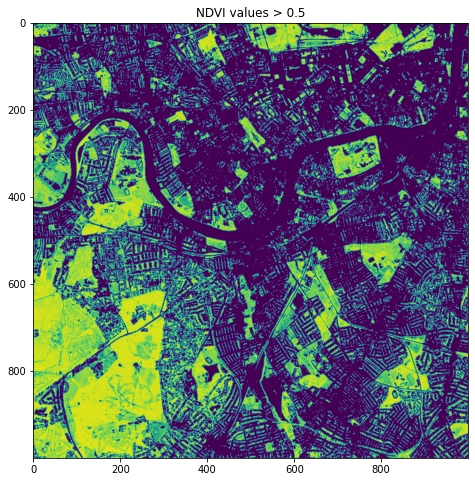

In [37]:
plt.figure(figsize=(8,8))
plt.imshow(mask*im1_ndvi,'viridis')
plt.title('NDVI values > '+str(vegetation_threshold))
plt.show()

Now let's do the same thing, but for the water threshold:

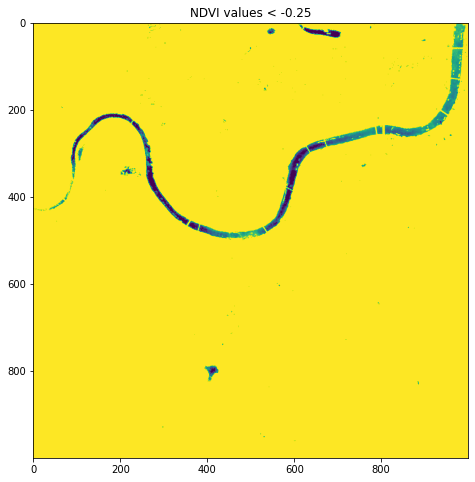

In [38]:
# keep all values below the water_threshold:
mask1 = im1_ndvi < water_threshold

# calculate the area above threshold in square-km:
area = (mask1.sum()*100)/1e6

# plot
plt.figure(figsize=(8,8))
plt.imshow(mask1*im1_ndvi,'viridis')
plt.title('NDVI values < '+str(water_threshold))
plt.show()

---

That's the end of this tutorial. Now it's your turn!